当前运行设备: cpu
正在加载模型: nvidia/segformer-b0-finetuned-ade-512-512 ...


D:\ana\Lib\site-packages\transformers\image_processing_base.py:370: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

正在进行语义分割...


D:\ana\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ana\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ana\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ana\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ana\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ana\Lib\site-packages\IPython\core\pylabto

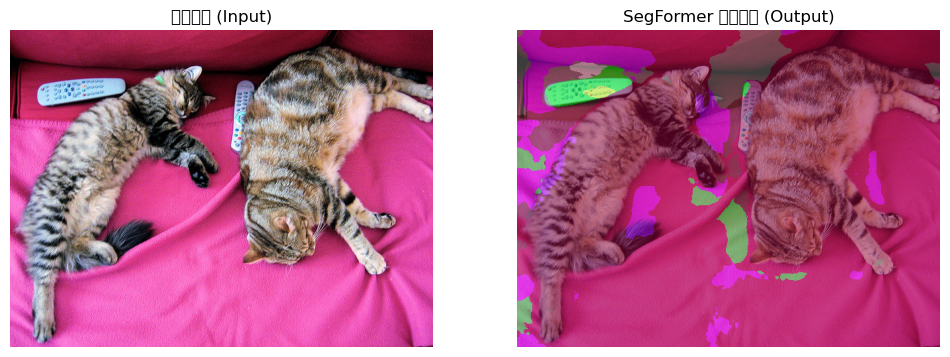

In [1]:
import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import numpy as np

# ==========================================
# 1. 设置设备与模型
# ==========================================
# 自动检测是否有显卡，没有则使用 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"当前运行设备: {device}")

# 加载 SegFormer-B0 (你报告中提到的轻量级模型)
MODEL_NAME = "nvidia/segformer-b0-finetuned-ade-512-512"
print(f"正在加载模型: {MODEL_NAME} ...")

processor = SegformerImageProcessor.from_pretrained(MODEL_NAME)
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME).to(device)

# ==========================================
# 2. 读取图片
# ==========================================
def load_image(url):
    return Image.open(requests.get(url, stream=True).raw)

# 使用一张街道场景图
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = load_image(url)

# ==========================================
# 3. 模型推理
# ==========================================
print("正在进行语义分割...")
inputs = processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # 输出形状: (batch, num_labels, h/4, w/4)

# 将输出插值放大回原图尺寸
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode="bilinear",
    align_corners=False,
)

# 获取预测结果 (每个像素的类别索引)
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# ==========================================
# 4. 可视化结果
# ==========================================
# ADE20K 颜色表 (部分)
def get_ade_palette():
    return np.array([
        [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
        [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
        [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
        [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82]
    ])

# 给分割图上色
palette = get_ade_palette()
# 简单的循环映射颜色（为了防止类别数超过颜色表长度）
color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
for label in np.unique(pred_seg):
    color = palette[label % len(palette)]
    color_seg[pred_seg == label] = color

# 图像融合显示
img_np = np.array(image)
vis_img = (img_np * 0.5 + color_seg * 0.5).astype(np.uint8)

# 在 Notebook 中绘图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("原始图像 (Input)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(vis_img)
plt.title("SegFormer 分割结果 (Output)")
plt.axis('off')

plt.show()